# 1.0 Libaries

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable

import numpy as np

import os

import matplotlib.pyplot as plt

# 2.0 Generall

In [19]:
print('Cuda is available:',torch.cuda.is_available(),'\n')

Cuda is available: False 



# 3.0 Hyperparameters

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_dim = 128

batch_size = 256

num_epochs = 3
learn_rate = 0.0006


# 4.0 Load Data

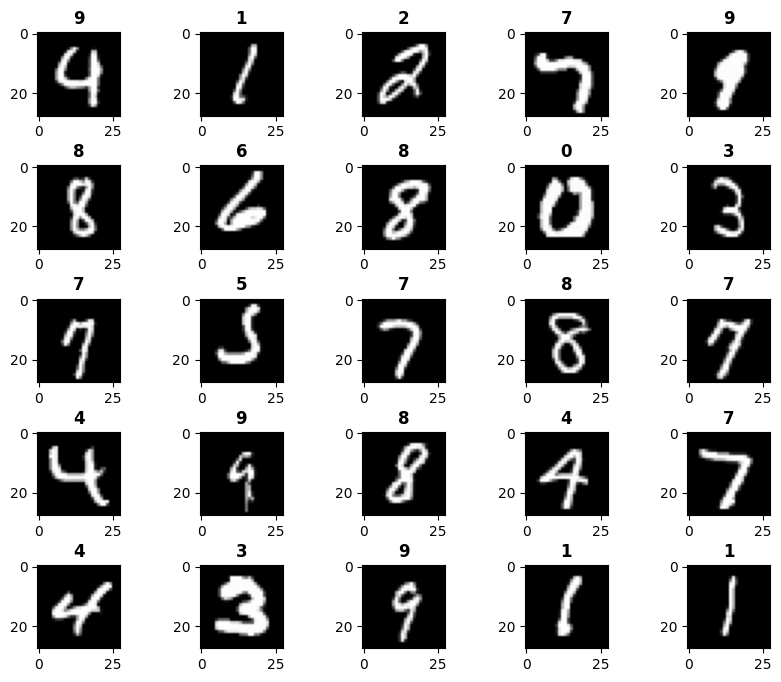

In [21]:
# create folder structure if it does not exist
folder_path = "../../data/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


#MNIST Dataset
    #Create Folder, transorm to Tensor
train_dataset = torchvision.datasets.MNIST(
    root=folder_path, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.01307),(0.3081))]), download=True
)

test_dataset = torchvision.datasets.MNIST(
    root=folder_path, train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.01307),(0.3081))])
)

#Data Loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)

#show MNIST Dataset

figure= plt.figure(figsize=(10,8))
spalten, zeilen = 5,5
for i in range(1,spalten*zeilen+1):
    sample_idx = torch.randint(len(train_dataset),size=(1,)).item()
    image , label = train_dataset[sample_idx]
    figure.add_subplot(spalten,zeilen,i)
    plt.title(label, weight='bold')
    plt.imshow(image.squeeze(), cmap='gray')
plt.subplots_adjust(wspace=0.3,hspace=0.6)
plt.show()


# 5.0 Classes

In [22]:
# Load necessary models for classification
    # reduce complexitiy and mass of code

import sys

sys.path.append('../../src/')

from classes.autoencoder.autoencoderCNN import AutoEncoder
from classes.imageclassification.classification import MNIST_Classification_Class

## 5.1 Load AE Model

In [23]:
#Define AutoEncoder Model and use encode 

ModelAE = AutoEncoder().to(device)

ModelAE.eval()

trained_encoder = ModelAE.encode


## 5.2 Load Classification Model

In [24]:
#define Image classification model 

ModelClassification = MNIST_Classification_Class(hidden_dim).to(device)

#  6.0 Function: View Predictions

In [25]:
def view_classifications(img,pred,AE9):
    pred = pred.cpu().data.numpy().squeeze()

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(6,9), ncols=3) 
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze())
    ax1.set_title('Original MNIST Image')
    
    bars = ax2.barh(np.arange(10), pred)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))               #Create bar graph to display prediction probability
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    ax3.matshow(AE9)
    ax3.set_title('Encoded Values')

    for bar, val in zip(bars, pred):
        if not (val < 0.3):
            ax2.text(val, bar.get_y() + bar.get_height() / 2, round(val, 2), va='center')

    plt.tight_layout()
    plt.show()
    plt.close()

# 7.0 Training

In [26]:
#Load Model / Continue Training
continue_training = False

FILE_Model1 = "model1.pth"

if continue_training:
    ModelClassification = torch.load(FILE_Model1).to(device)

#criterion / lf
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.Adam(params=ModelClassification.parameters(),lr=learn_rate)

for epoch in range(num_epochs):
    for batch_id, (Bild,Label) in enumerate(train_loader):
        Bild = Bild.to(device)  #[100, 1,28,28] > [100,734] ?
        Label = Label.to(device)

        outputAE = trained_encoder(Bild)
        outputAE = outputAE.to(device)
        
        output = ModelClassification(outputAE) #was macht out?
        loss = criterion(output,Label) #hier out?!

        if batch_id %50 == 0:
            print('Image:',batch_id+1,'of',batch_size,'in Epoche:',epoch+1,'// Loss: %.5f ' % loss)
            view_classifications(Bild[0].cpu().view(1,28,28),output[0],outputAE[0].detach().numpy().reshape(1,9))
        

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
    print('Epoche:',epoch+1, 'Loss: %.5f ' % loss)
    
    # if epoch %2 == 0:
    #     view_classifications(Bild[0].view(1,28,28),output[0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8192x4 and 9x128)

# 8.0 Save Model Neural Network

In [ ]:
# torch.save(model1,FILE_Model1)

# Confusuion Matrix

In [ ]:
# label_list = torch.zeros(batch_size)
# pred_list = torch.zeros(batch_size)

# print(label_list, pred_list)

# with torch.no_grad():
#     for data,target in test_dataset:
#         data = data.reshape(-1,28,28).to(device)
#         target = target.to(device)

#         outconf= model1(data)

        

# Evaluation

In [ ]:
# model1 = torch.load(FILE)

# with torch.no_grad():
#     for batch_id, (data,target) in enumerate(test_loader):
#         data = data.reshape(-1,28*28).to(device)  #[100, 1,28,28] > [100,734] ?
#         target = target.to(device)
        
#         output = model1(data) #was macht out?
#         loss = criterion(output,target) #hier out?!

#         view_classifications(data[0].view(1,28,28),output[0])
#         print('Batch in Epoche ',batch_id+1, 'Loss: %.5f ' % loss)

#     print('Epoche:',epoch+1, 'Loss: %.5f ' % loss)
